In [28]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
from matplotlib.pyplot import figure
import hickle as hkl
import time
import datetime

from matplotlib.animation import FuncAnimation
import psutil
import collections
import os
from IPython.display import clear_output

import copy

import scipy
from scipy import stats

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# MediaPipe hand delay test

In [7]:
# 计算2d三角形面积公式
def heron(a,b,c):  
    s = (a + b + c) / 2   
    area = (s*(s-a) * (s-b)*(s-c)) ** 0.5        
    return area

def distance2d(x1,y1,z1,x2,y2,z2):    
    a=(x1-x2)**2+(y1-y2)**2
    d= a ** 0.5  
    return d  

def areatriangle2d(x1,y1,z1,x2,y2,z2,x3,y3,z3):  
    a=distance2d(x1,y1,z1,x2,y2,z2)  
    b=distance2d(x2,y2,z2,x3,y3,z3)  
    c=distance2d(x3,y3,z3,x1,y1,z1)  
    A = heron(a,b,c)  
    print("area of triangle is %r " %A)
    
def areatriangle2d_By_Points(p1,p2,p3,w,h):  
    x1 = p1.x*w
    y1 = p1.y*h
    z1 = p1.z*w
    
    x2 = p2.x*w
    y2 = p2.y*h
    z2 = p2.z*w
    
    x3 = p3.x*w
    y3 = p3.y*h
    z3 = p3.z*w
    
#     z1 = 0
#     z2 = 0
#     z3 = 0
    a=distance2d(x1,y1,z1,x2,y2,z2)  
    b=distance2d(x2,y2,z2,x3,y3,z3)  
    c=distance2d(x3,y3,z3,x1,y1,z1)  
    A = heron(a,b,c)
    return A


def areatriangle2d_sum(hand_landmarks,w,h): 
    extract_point = [4,8,12,16,20,0]
    p = []
    for i in extract_point:
        p.append(hand_landmarks.landmark[i])
    a1 = areatriangle2d_By_Points(p[0],p[1],p[2],w,h)
    a2 = areatriangle2d_By_Points(p[0],p[2],p[3],w,h)
    a3 = areatriangle2d_By_Points(p[0],p[3],p[4],w,h)
    a4 = areatriangle2d_By_Points(p[0],p[4],p[5],w,h)
    
    a = a1+a2+a3+a4
    return a


In [22]:
# Read and redraw image information by time, index, stored coordinates, and image information
# test the 2D area stable in the video stream
def hand_area_tracking_recording(filename): 

    now = datetime.datetime.now()
    now_ts = time.time()
    data_s = []
    index_s = []
    time_s = []
    result_s = []
    image_s = []
    image_size = []
    idx = 0
    
    t_all = 0
    t_cal = 0
    time_delay = []

    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands


    hand_area = collections.deque(np.zeros(500))
    hand_z = collections.deque(np.zeros(500))

    hand_z1 = collections.deque(np.zeros(500))
    hand_z2 = collections.deque(np.zeros(500))
    hand_z3 = collections.deque(np.zeros(500))
    hand_z4 = collections.deque(np.zeros(500))

    cap = cv2.VideoCapture(0)
    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_detection_confidence=0.8,
        min_tracking_confidence=0.8) as hands:
        ts_t = 0
        while cap.isOpened():
            success, image = cap.read()
            t_all = t_all+1
            ts = time.time()
            if not success:
              print("Ignoring empty camera frame.")
              continue

            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = hands.process(image)
            image_height, image_width, _ = image.shape
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)



            if results.multi_hand_landmarks:
              t_cal = t_cal+1
              index_s.append(idx)
              time_s.append(ts)
              result_s.append(results.multi_hand_landmarks)
              for hand_landmarks in results.multi_hand_landmarks:
                clear_output(wait=True)
                hand_area.popleft()
                hand_z.popleft()
                area = areatriangle2d_sum(hand_landmarks,image_width,image_height)
                hand_area.append(ts_t*1000)
                hand_z.append(hand_landmarks.landmark[4].z)


                plt.plot(hand_area)
                plt.title("Hand area tracking delay")
                plt.xlabel("Frame number")
                plt.ylabel("Delay by ms")
                plt.show()
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())
            image = cv2.flip(image, 1)
            if len(time_s)>1:
                cv2.putText(image, "FPS: " + str(round(1.0 / (time_s[-1] - time_s[-2]),0)), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                            (0, 255, 0), 2, )
            cv2.imshow('MediaPipe Hands', image)
            ts_t = time.time() - ts
            time_delay.append(ts_t)
            idx = idx + 1
            if cv2.waitKey(5) & 0xFF == 27:
              break
    cap.release()
    cv2.destroyAllWindows()
    for i in range (1,5):
        cv2.waitKey(1)
    

    data_s.append(time_delay)  
    data_s.append(t_all)
    data_s.append(t_cal)
    print(t_all)
    print(t_cal)
    print(t_cal/t_all)
    print(np.mean(np.array(time_delay)))
    fname = filename+'.hkl'
    hkl.dump(data_s, fname, mode='w', compression='gzip')
    print("data save success on: "+fname)
    tm_out = round((ts - now_ts),2)
    print("total time: " + str(tm_out)+' s')
    f_size = round(os.path.getsize(fname)/1048576,2)
    print("file size: " + str(f_size)+" MB")
    return data_s, fname

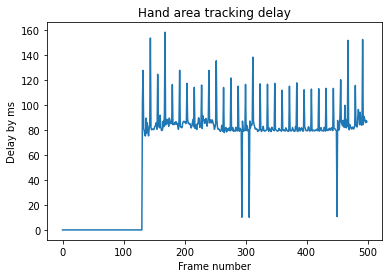

384
369
0.9609375
0.08317629372080167
data save success on: delay_test.hkl
total time: 46.63 s
file size: 0.01 MB


In [27]:
filename = 'delay_test'
data_s, fname = hand_area_tracking_recording(filename)

# MediaPipe pose delay test

In [29]:
def angle_calculate(holistic_landmarks,w,h): 
#     left/right three point
    arm_points = [11, 13, 15, 12, 14, 16]
    
    angle1 = -1
    angle2 = -1
    if holistic_landmarks:
        ldm = holistic_landmarks.landmark
        if ldm[arm_points[0]] and ldm[arm_points[1]] and ldm[arm_points[2]]:
            a1 = np.array([ldm[arm_points[0]].x*w ,ldm[arm_points[0]].y*h])
            b1 = np.array([ldm[arm_points[1]].x*w ,ldm[arm_points[1]].y*h])
            c1 = np.array([ldm[arm_points[2]].x*w ,ldm[arm_points[2]].y*h])

            ba1 = a1 - b1
            bc1 = c1 - b1

            cosine_angle1 = np.dot(ba1, bc1) / (np.linalg.norm(ba1) * np.linalg.norm(bc1))
            angle1 = np.arccos(cosine_angle1)/np.pi*180

        if ldm[arm_points[3]] and ldm[arm_points[4]] and ldm[arm_points[5]]:
            a2 = np.array([ldm[arm_points[3]].x*w ,ldm[arm_points[3]].y*h])
            b2 = np.array([ldm[arm_points[4]].x*w ,ldm[arm_points[4]].y*h])
            c2 = np.array([ldm[arm_points[5]].x*w ,ldm[arm_points[5]].y*h])

            ba2 = a2 - b2
            bc2 = c2 - b2

            cosine_angle2 = np.dot(ba2, bc2) / (np.linalg.norm(ba2) * np.linalg.norm(bc2))
            angle2 = np.arccos(cosine_angle2)/np.pi*180
    return [angle1, angle2]
    

In [40]:
# 按照 时间, index, 存储 坐标和图像信息, 读取并重新画图分析
# test the 2D area stable in the video stream
def pose_tracking_recording(filename): 

    now = datetime.datetime.now()
    now_ts = time.time()
    data_s = []
    index_s = []
    time_s = []
    result_s = []
    image_s = []
    image_size = []
    idx = 0
    
    face_data = []
    pose_data = []
    left_hand_data = []
    right_hand_data = []
    
    t_all = 0
    t_cal = 0
    time_delay = []

    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    


    arm_angle_left = collections.deque(np.zeros(500))
    arm_angle_right = collections.deque(np.zeros(500))
    cap = cv2.VideoCapture(0)
    with mp_pose.Pose(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        min_detection_confidence=0.5) as pose:
        ts_t = 0
        while cap.isOpened():
            success, image = cap.read()
            t_cal = t_cal+1
            ts = time.time()
            time_s.append(ts)

            t_all = t_all+1
            if not success:
                continue

            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = pose.process(image)

            image_height, image_width, _ = image.shape
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            pose_data.append(results.pose_landmarks)


            mp_drawing.draw_landmarks(
                 image,
                 results.pose_landmarks,
                 mp_pose.POSE_CONNECTIONS,
                 mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=4),
                 mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2))

            ang = angle_calculate(results.pose_landmarks,image_width,image_height)
            arm_angle_left.popleft()
            arm_angle_left.append(ang[0])
            arm_angle_right.popleft()
            arm_angle_right.append(ts_t*1000)

            clear_output(wait=True)


            name = 'angle_arm1'
            angle_right = ang[1]
            stp = ts

            plt.plot(arm_angle_right)
            plt.title("Arm angle tracking delay")
            plt.xlabel("Frame number")
            plt.ylabel("Delay by ms")

            plt.show()

            image = cv2.flip(image, 1)
            if len(time_s)>1:
                cv2.putText(image, "FPS: " + str(round(1.0 / (time_s[-1] - time_s[-2]),0)), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                            (0, 255, 0), 2, )
            cv2.imshow('MediaPipe Holistic', image)
            ts_t = time.time() - ts
            time_delay.append(ts_t)
            idx = idx + 1
            if cv2.waitKey(5) & 0xFF == 27:
              break
    cap.release()
    cv2.destroyAllWindows()
    for i in range (1,5):
        cv2.waitKey(1)

    data_s.append(time_delay)  
    data_s.append(t_all)
    data_s.append(t_cal)
    print(t_all)
    print(t_cal)
    print(t_cal/t_all)
    print(np.mean(np.array(time_delay)))
    
    fname = filename+'.hkl'
    hkl.dump(data_s, fname, mode='w', compression='gzip')
    print("data save success on: "+fname)
    tm_out = round((ts - now_ts),2)
    print("total time: " + str(tm_out)+' s')
    f_size = round(os.path.getsize(fname)/1048576,2)
    print("file size: " + str(f_size)+" MB")
    return data_s, fname

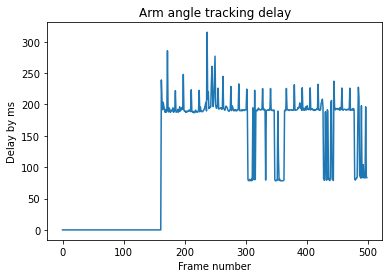

339
339
1.0
0.1782858660087473
data save success on: pose_delay_test.hkl
total time: 75.34 s
file size: 0.01 MB


In [41]:
filename = "pose_delay_test"
# filename = "pose_right_bare_10"
data_s, fname = pose_tracking_recording(filename)